# Frequency Distributions

See notes 20.021.Frequency_Distributions.md

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.core.display import HTML, display
from importlib import reload
import scipy.stats as ss

# pandas options 
pd.set_option('max_rows', 50)
pd.set_option('max_columns', 30)
pd.set_option('display.max_colwidth', 150)

# matplotlib and plotting options 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# seaborn options 
sns.set(context='paper', style='darkgrid', font='serif')
# sns.set(context='paper', style='ticks', font='serif')

# warnings
import warnings
# warnings.simplefilter('error')
# warnings.simplefilter('ignore')

# this file is in examples
import sys
sys.path.insert(0,'/s/telos/python/aggregate_project/')
import aggregate as agg

import aggregate.parser as parser
import aggregate.underwriter as trash
uw = trash.Underwriter(debug=False)
from aggregate.utils import sgamma_fit, MomentAggregator


In [ ]:
sns.palplot(sns.color_palette("husl", 7))
sns.palplot(sns.color_palette("Paired", 8))
sns.set_palette(sns.color_palette("Paired", 8))
current_palette = sns.color_palette()
sns.palplot(current_palette)

In [2]:
ft = lambda x: np.fft.fft(x)

ift = lambda x : np.fft.ifft(x)

In [220]:
def mixing(n, ν, f, κ, log2, xmax=500, **kwds):
    """
    n = E(N) = expected claim count
    ν = CV(mixing) = asymptotic CV of any compound aggregate whose severity has a second moment
    f = proportion of certain claims, 0 <= f < 1, higher f corresponds to greater skewnesss
    κ = claims per occurrence 
    """
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    ma = lambda x : list(MomentAggregator._moments_to_mcvsk(*x))
    
    def row(ps):
        moms = [(x**k * ps).sum() for k in (1,2,3)] 
        stats = ma(moms)
        return moms + stats + [np.nan]

    def Nmoms(n, c, g):
        """ 
        c=Var(G), g=E(G^3) return EN, EN2, EN3 
        """
        return [n, n * (1 + (1 + c) * n), n * (1 + n * (3*(1+c) + n * g))]
    
    def asy_skew(g, c):
        """
        asymptotic skewnewss 
        """
        return [(g - 3 * c - 1) / c**1.5]
    
    ans = pd.DataFrame(columns=['X', 'type', 'EX', 'EX2', 'EX3', 'mean', 'CV', 'Skew',  'Asym Skew'])
    ans = ans.set_index(['X', 'type'])

    N = 1 << log2
    x = np.arange(N, dtype=float)
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
        
    # build poisson for comparison
    dist = 'poisson'
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)

    # for poisson c=0 and g=1 (the "mixing" distribution is G identically equal to 1)
    ans.loc[(dist, 'empirical'), :] = row(p)
    temp = Nmoms(n, 0, 1)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + [np.inf]
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    # negative binomial
    # Var(G) = c, E(G)=1 so Var(G) = ν^2 = c
    # wikipedia / scipy stats use a and θ for shape and scale
    dist = 'neg bin'
    c = ν * ν   # contagion
    a = 1 / c
    θ = c
    # E(G^3): skew(G) = skew(G') = γ, so E(G-EG)^3 = γν^3, so EG^3 = γν^3 + 3(1+c) - 2 = γν^3 + 3c + 1
    # for Gamma skew = 2 / sqrt(a) = 2ν
    g = 1 + 3*c + 2*c*c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    ans.loc[(dist, 'empirical'), :] = row(nb)
    # this row is generic: it applies to all distributions 
    temp = Nmoms(n, c, g)   # [n, n * (1 + (1 + c) * n), n*(1 + n * (3*(1+c) + n * g))] # n**3*g + 3*n**2*(1+c)+n]
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
        
    # delaporte G = f + G'
    dist = 'delaporte'
    c = ν * ν   # contagion
    a = ((1 - f) / ν)**2
    θ = (1 - f) / a
    g = 2 * ν**4 / (1-f) + 3 * c + 1
    delaporte = np.real(ift( np.exp(f * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)

    ans.loc[(dist, 'empirical'), :] = row(delaporte)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # pig
    dist = 'pig'
    c = ν * ν   # contagion
    μ = c
    λ = 1 / μ
    # our param (λ, μ) --> (λ, λμ) in Mathematica and hence skew = γ = 3 * sqrt(μ) in scip py parameterization 
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    pig = np.real(ift( np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)) )))
    pig = defuzz(pig)
    print(f'PIG parameters μ={μ} and λ={λ}, g={g}, γ={γ}')
    ans.loc[(dist, 'empirical'), :] = row(pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # shifted pig
    dist = 'shifted pig'
    c = ν * ν   # contagion
    μ = c / (1 - f)**2 
    λ = (1 - f) / μ
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    shifted_pig = np.real(ift(  np.exp(f * kernel) * np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)))))
    shifted_pig = defuzz(shifted_pig)
    
    ans.loc[(dist, 'empirical'), :] = row(shifted_pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    #  poisson pascal 
    # parameters 
    dist = 'poisson pascal'
    # solve for local c to hit overall c=ν^2 value input
    c = (n * ν**2 - 1 - κ) / κ
    a = 1 / c
    θ = κ * c
    λ = n / κ   # poisson parameter for number of claims
    pois_pascal = np.real(ift( np.exp(λ * ((1 - θ * (fz - 1))**-a - 1))))
    pois_pascal = defuzz(pois_pascal)
    
    ans.loc[(dist, 'empirical'), :] = row(pois_pascal)
    # moments for the PP are different can't use Nmoms
    g = κ*λ*(2*c**2*κ**2 + 3*c*κ**2*λ + 3*c*κ**2 + 3*c*κ + κ**2*λ**2 + 3*κ**2*λ + κ**2 + 3*κ*λ + 3*κ + 1)
    g2 = n*(2*c**2*κ**2 + 3*c*n*κ + 3*c*κ**2 + 3*c*κ + n**2 + 3*n*κ + 3*n + κ**2 + 3*κ + 1)
    print(g-g2)
    temp = [λ * κ, n * (κ * (1 + c + λ) + 1), g]
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + [np.nan]  # note: hard to interpret this, but for FIXED cv of NB it tends to zero
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    
    # sum of all errors is small 
    print( ans.loc[(slice(None), 'diff'), :].abs().sum().sum() )
#     assert ans.loc[(slice(None), 'diff'), :].abs().sum().sum() < 1e-6
    
    # graphic 
    df = pd.DataFrame(dict(x=x, poisson=p, pois_pascal=pois_pascal, negbin=nb, pig=pig, delaporte=delaporte, shifted_pig=shifted_pig))
    df = df.query(f' x < {xmax} ')
    f, ax = plt.subplots(1,2,figsize=(11,5))    
    df.plot(kind='line', x='x', ax=ax[0], **kwds)
    ax[0].set_xlim(0, 4*n)
    df.plot(kind='line', x='x', logy=True, ax=ax[1], **kwds)

    # asymptotic moments 
#     asNCV = np.sqrt(c)
#     asNSK = 2 * cv
#     delSK = 2 / np.sqrt(a)
   
    display(ans)
    return df, ans

0.0
1.19825333877e-07


EX          EX2          EX3  \
X              type                                                 
poisson        empirical             90         8190       753390   
               theoretical           90         8190       753390   
               diff        -2.38698e-14 -4.59632e-14 -7.60503e-14   
neg bin        empirical             90        13374  2.76582e+06   
               theoretical           90        13374  2.76582e+06   
               diff        -9.25926e-13 -1.05882e-11 -9.59098e-11   
delaporte      empirical             90        13374  4.55741e+06   
               theoretical           90        13374  4.55741e+06   
               diff        -8.22842e-12 -3.14716e-10 -5.43426e-09   
pig            empirical             90        13374  3.06442e+06   
               theoretical           90        13374  3.06442e+06   
               diff        -2.36022e-12 -4.55992e-11 -6.07689e-10   
shifted pig    empirical             90        13374   5.7518e+06   
               theoretical           90        13374   5.7518e+06   
               diff        -2.58713e-11 -1.72955e-09 -4.07769e-08   
poisson pascal empirical             90        13284  2.70286e+06   
               theoretical           90        13284  2.70286e+06   
               diff         -8.4921e-13 -9.23861e-12 -8.07002e-11   

                                   mean           CV         Skew Asym Skew  
X              type                                                          
poisson        empirical             90     0.105409     0.105409       NaN  
               theoretical           90     0.105409     0.105409       inf  
               diff        -2.38698e-14   7.9492e-14 -8.29511e-11       NaN  
neg bin        empirical             90     0.806915      1.60006       NaN  
               theoretical           90     0.806915      1.60006       1.6  
               diff        -9.25926e-13  -1.1077e-11 -3.35609e-10       NaN  
delaporte      empirical             90     0.806915      6.27772       NaN  
               theoretical           90     0.806915      6.27772       6.4  
               diff        -8.22842e-12 -3.78168e-10 -8.67099e-09       NaN  
pig            empirical             90     0.806915      2.37967       NaN  
               theoretical           90     0.806915      2.37967       2.4  
               diff        -2.36022e-12 -5.18308e-11 -1.70191e-09       NaN  
shifted pig    empirical             90     0.806915      9.39616       NaN  
               theoretical           90     0.806915      9.39616       9.6  
               diff        -2.58713e-11 -2.12732e-09 -5.69821e-08       NaN  
poisson pascal empirical             90          0.8      1.53834       NaN  
               theoretical           90          0.8      1.53834       NaN  
               diff         -8.4921e-13 -9.66105e-12 -2.91806e-10       NaN

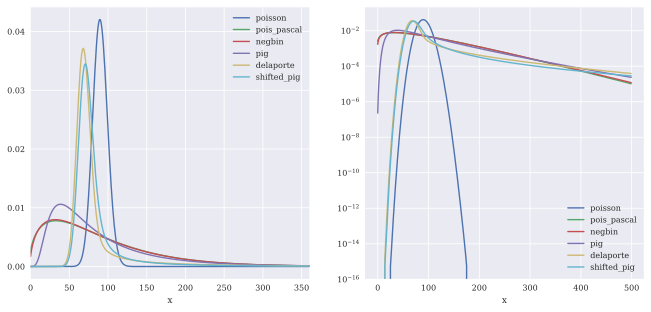

In [7]:
df, ans = mixing(90, 0.8, 0.75, 3.5, 16, xmax=500);

In [366]:
from scipy.special import kv

def sichel(μ, β, λ, log2, **kwds):
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x

    def expand_moms(f1, f2, f3, emp1, emp2, emp3):
        """
        turn factorial moments f1 f2 f3 into more informative stats 
        """
        ex1 = f1 
        ex2 = f2 + f1
        ex3 = f3 + 3 *  f2 + f1
        m = ex1
        v = ex2 - m*m
        sd = np.sqrt(v)
        cv = sd/m
        c3 = ex3 - 3*ex2*ex1 + 2*ex1**3
        γ = c3 / sd**3
        return pd.Series((ex1, emp1, ex2, emp2, ex3, emp3, m, v, sd, cv, c3, γ), 
                         index=( 'EX', 'est EX', 'EX2', 'est EX2', 'EX3', 'est EX3',  'm', 'v', 'sd', 'cv', 'c3', 'γ'))
        
    # basic set up
    N = 1<<log2
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)    
    x = np.arange(N, dtype=float)
    z[1] = 1
    fz = ft(z)
    kernel = (fz - 1)
        
    # sichel
    dist = 'sichel'
    factorial = [μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]
    print('params:', μ, β, λ)
    print('fact moms', factorial)
    inner = np.sqrt(1 - 2 * β * kernel)
    sichel = np.real(ift( inner**(-λ) * kv(λ, μ * inner / β) /  kv(λ, μ / β) ))
    print('sum of probs error', sichel.sum()-1)
    moms = [(x**k * sichel).sum() for k in (1,2,3)] 
    em = expand_moms(*factorial, *moms)
    mw = MomentWrangler()
    mw.factorial = factorial
    print('em manual\n', em)
    print('mw.stats\n', mw.stats)
    # poisson for comparison
    dist = 'poisson'
    n = em[0]  # mean for Poisson comparison  
    p = np.real(ift(np.exp(n * kernel)))
    p = defuzz(p)

    df = pd.DataFrame(dict(x=x, p=p, sichel=sichel))
    df.plot(kind='line', x='x')
    df.plot(kind='line', x='x', logy=True)
    
    return em, df

params: 100 1.234 -0.5
fact moms [100.0, 10123.400000000001, 1037476.8267999999]
sum of probs error 0.0
em manual
 EX         1.000000e+02
est EX     1.000000e+02
EX2        1.022340e+04
est EX2    1.022340e+04
EX3        1.067947e+06
est EX3    1.067947e+06
m          1.000000e+02
v          2.234000e+02
sd         1.494657e+01
cv         1.494657e-01
c3         9.270268e+02
γ          2.776307e-01
dtype: float64
mw.stats
 ex      100.000000
var     223.400000
sd       14.946572
cv        0.149466
skew      0.277631
dtype: float64


,x,p,sichel
0,0.0,0.0,1.374768e-16
1,1.0,0.0,1.345495e-16
2,2.0,0.0,1.359590e-16
3,3.0,0.0,1.336821e-16
4,4.0,0.0,1.356337e-16


EX         1.000000e+02
est EX     1.000000e+02
EX2        1.022340e+04
est EX2    1.022340e+04
EX3        1.067947e+06
est EX3    1.067947e+06
m          1.000000e+02
v          2.234000e+02
sd         1.494657e+01
cv         1.494657e-01
c3         9.270268e+02
γ          2.776307e-01
dtype: float64

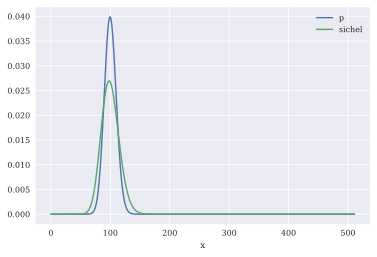

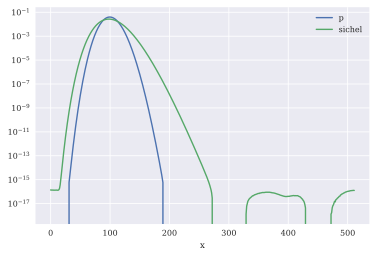

In [367]:
em, df = sichel(100, 1.234, -0.5, 9)
display(df.head())
em

# Solving for Sichel Parameters  

In [193]:
from scipy.optimize import newton_krylov, broyden2
from scipy.optimize.nonlin import NoConvergence

In [124]:
def f(arrIn):
    μ, β, λ = arrIn
    target = np.array([100.0, 10123.400000000001, 1037476.8267999999])
    return np.array([μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]) - target

In [119]:
guess = np.array((90, 1.2, -0.4)) ## 100 1.234 -0.5
target = np.array([100.0, 10123.400000000001, 1037476.8267999999])

In [120]:
f((100, 1.23, -0.5))

(100, 1.23, -0.5)


array([   0.    ,   -0.4   , -122.9568])

In [149]:
newton_krylov(f, (101, 1.23, -0.5), verbose=False, f_rtol=1e-12)

array([ 99.99999995,   1.234     ,  -0.49999996])

In [159]:
%timeit newton_krylov(f, (101, 1.23, -0.5), verbose=False, f_rtol=1e-12)

227 ms ± 9.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
broyden2(f, (101, 1.23, -0.5), verbose=False, f_rtol=1e-9)

array([ 100.00000041,    1.23400001,   -0.50000033])

In [160]:
%timeit broyden2(f, (101, 1.23, -0.5), verbose=False, f_rtol=1e-9)

58.7 ms ± 938 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [127]:
f([ 99.99472192,   1.23393579,  -0.49569666])

array([ -2.61492758e-07,  -4.18807758e-07,  -7.69186299e-05])

In [422]:
def sichel_solver(n, ν, γ):
    """
    find method of moments parameters for Sichel to match EN, CVN and EN^3 as given CV ν OF THE MIXING dist
    and skewness γ of RESULTING distribution     
    """
    # starting parameters = PIG estimates in Panjer Willmot p. format 
    c = ν ** 2
    λ = -0.5
    μ = n
    β = ν**2 * n

    # implied non-central moments 
    en1 = n
    en2 = n * (1 + (1 + c) * n)
    vn = n * (1 + c * n)
    en3 = γ * vn**1.5 + 3 * en2 * en1 - 2 * en1**3
    # target factorial moments 
    f1 = en1
    f2 = en2 - en1
    f3 = en3 - 3 * en2 + 2 * en1
    target = np.array((f1, f2, f3))

    pig_fact = tuple((μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1, 2,3)))
    mw = MomentWrangler()
    mw.noncentral = (en1, en2, en3)
    print(f'parameters(μ, β, λ) =   {(μ, β, λ)}')
    print(f'factorial mos of PIG  = {pig_fact}')
    print(f'target factorial =                {target}')
    print(f'mw factorial =                    {mw.factorial}')   

    tf = mw.stats
    mw.factorial = pig_fact
    df0 = pd.DataFrame({'target': tf, 'pig': mw.stats})
    display(df0)
    
    def f(arrIn):
        μ, β, λ = arrIn
#         if f.counter % 100 == 0:
#             print(f.counter, arrIn)
#         f.counter += 1
        return np.array([μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]) - target
#     f.counter = 0
    try:
        ans = broyden2(f, (μ, β, λ), verbose=False, iter=10000, f_rtol=1e-11) # , f_rtol=1e-9)  , line_search='wolfe'
    except NoConvergence as e:
        print('ERROR: broyden did not converge')
        print(e)
#     try:
#         ans = newton_krylov(f, (μ, β, λ)) # , f_rtol=1e-9)
#     except NoConvergence as e:
#         print('ERROR: newton_krylov did not converge')
#         print(e)
        raise e
    return ans

In [423]:
params = sichel_solver(100, 0.45, 1.6)  # 1.31887
params

parameters(μ, β, λ) =   (100, 20.25, -0.5)
factorial mos of PIG  = (100.0, 12025.0, 1730518.7500000002)
target factorial =                [  1.00000000e+02   1.20250000e+04   1.75805726e+06]
mw factorial =                    (100, 12025.000000000002, 1758057.2557739802)


,target,pig
ex,100.000000,100.000000
var,2125.000000,2125.000000
sd,46.097722,46.097722
cv,0.460977,0.460977
skew,1.600000,1.318873


array([ 100.79241123,   21.70137996,   -0.56782587])

In [542]:
def sichel_solver2(n, ν, γ_mult):
    """
    find method of moments parameters for Sichel mixed with GIG whose skewness = γ_mult x IG(n, ν) 
    """
    # starting parameters = IG estimates in Panjer Willmot p.282 (8.3.12) and (8.3.13) format 
    c = ν ** 2
    λ = -0.5
    μ = n
    β = ν**2 * n
    ig_param = (μ, β, λ)
    # EG^3
    ig_fact = tuple((μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1, 2,3)))
    mw = MomentWrangler()
    mw.factorial = ig_fact
    γ_base = mw.stats['skew']
    sd_base = mw.stats['sd']
    eg, eg2, eg3 = mw.noncentral 
    print(eg, eg2, eg3)
    γ = γ_base * γ_mult
    # adjust the third moment (mean and std dev unchanged)
    eg3_target = γ * sd_base**3 + 3 * eg2 * eg - 2 * eg**3
    mw.noncentral = (eg, eg2, eg3_target)
    target = np.array(mw.factorial)
    print(target)

    def f(arrIn):
        μ, β, λ = arrIn
        # mu and beta are positive... 
        μ = np.exp(μ)
        β = np.exp(β)
        return np.array([μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]) - target

    try:
        ans = broyden2(f, (np.log(μ), np.log(β), λ), verbose=False, iter=10000, f_rtol=1e-11) # , f_rtol=1e-9)  , line_search='wolfe'
    except NoConvergence as e:
        print('ERROR: broyden did not converge')
        print(e)
        raise e
    μ, β, λ = ans
    ans = (np.exp(μ), np.exp(β), λ)
    print('ig', ig_param, 'gig', ans)
    return 

In [543]:
params = sichel_solver2(40, 0.5, 2.25)

40.0 2040.0 130040.0
[  4.00000000e+01   2.00000000e+03   1.40550000e+05]


C:\Users\steve\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:1038: RuntimeWarning: invalid value encountered in true_divide
  d = v / df_norm**2
C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


ig (40, 10.0, -0.5) gig (367.39216307700769, 79.860604017327717, -7.6659421537149264)


In [545]:
a=1; b=2; c = (a, b)

In [546]:
c

(1, 2)

In [547]:
b=15

In [548]:
c

(1, 2)

In [537]:
params

(42.377214598771914, 11.426137497976219, -0.77424253232753837)

params: 367.392163077 79.8606040173 -7.66594215371
fact moms [113.14371414717861, 14513.756456394529, 2137268.7582834424]
sum of probs error 0.0
em manual
 EX         1.131437e+02
est EX     1.131266e+02
EX2        1.462690e+04
est EX2    1.461623e+04
EX3        2.180923e+06
est EX3    2.174646e+06
m          1.131437e+02
v          1.825400e+03
sd         4.272470e+01
cv         3.776145e-01
c3         1.129163e+05
γ          1.447836e+00
dtype: float64
mw.stats
 ex       113.143714
var     1825.400120
sd        42.724702
cv         0.377614
skew       1.447836
dtype: float64


,x,p,sichel
0,0.0,0.0,6.299091e-07
1,1.0,0.0,6.174707e-07
2,2.0,0.0,6.052903e-07
3,3.0,0.0,5.933621e-07
4,4.0,0.0,5.816809e-07


EX         1.131437e+02
est EX     1.131266e+02
EX2        1.462690e+04
est EX2    1.461623e+04
EX3        2.180923e+06
est EX3    2.174646e+06
m          1.131437e+02
v          1.825400e+03
sd         4.272470e+01
cv         3.776145e-01
c3         1.129163e+05
γ          1.447836e+00
dtype: float64

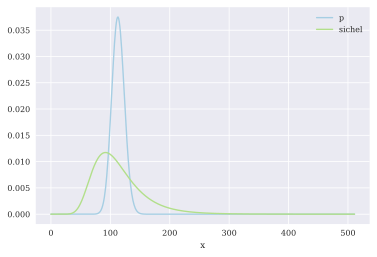

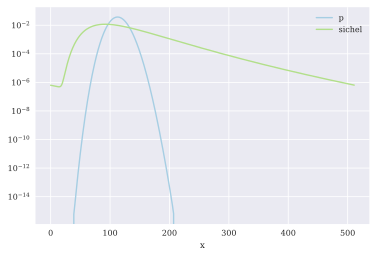

In [541]:
em, df = sichel(*params, 9)
display(df.head())
em

In [490]:
from scipy.optimize import newton

In [528]:
def sichel_solver3(n, ν, λ1):
    """
    find parameters for Sichel matching n and ν but with λ1 in place of λ=-0.5 (PIG)  
    """
    # starting parameters = IG estimates in Panjer Willmot p.282 (8.3.12) and (8.3.13) format 
    c = ν ** 2
    λ = -0.5
    μ = n
    β = ν**2 * n
    ig_param = (μ, β, λ)
    print('initial params', ig_param)
    # need to find β so that K_(λ+1)(mu/beta) / K_(λ)(mu/beta) = value for lambda=-0.5, will use NR
    target = kv(λ + 1, μ / β) / kv(λ, μ / β)
    print('target value', target)
    def f(β1):
        x = kv(λ1 + 1, μ / np.exp(β1)) / kv(λ1, μ / np.exp(β1))
#         print(np.exp(β1), x, x-target)
        return x - target
#         return kv(λ1 + 1, μ / β1) / kv(λ1, μ / β1) - target 
    
    print('should be close to zero: ', f(np.log(β) -2), f(np.log(β)), f(np.log(β) + 2))
    
    # newton(func, x0, fprime=None, args=(), tol=1.48e-08, maxiter=50, fprime2=None)[source]
    β1 = newton(f, np.log(β), maxiter=1000)
    
    
    print('ig', ig_param, 'gig', (μ, β1, λ1))
    return ans

In [530]:
sichel_solver3(40, 0.5, -0.45)

initial params (40, 10.0, -0.5)
target value 1.0
should be close to zero:  0.00166537952157 0.0112910525285 0.0581020093398


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


RuntimeError: Failed to converge after 1000 iterations, value is nan

In [509]:
n = 50
ν = 0.4
c = ν ** 2
λ = -0.5
μ = n
β = c * n
base = tuple((μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1, 2,3)))
mw = MomentWrangler()
mw.factorial = base 
print(base)
print(mw.stats)
df = pd.DataFrame(mw.stats, columns=[-0.5]).T
for l in np.linspace(-10, 10, 25):
    mw.factorial = tuple((μ**r * kv(l + r, μ / β) / kv(l, μ / β) for r in (1, 2,3)))
    df.loc[l, :] = mw.stats
df

(50.0, 2900.0, 194600.00000000003)
ex       50.000000
var     450.000000
sd       21.213203
cv        0.424264
skew      1.136609
dtype: float64


,ex,var,sd,cv,skew
-0.500000,50.000000,450.000000,21.213203,0.424264,1.136609
-10.000000,15.525143,38.874460,6.234939,0.401603,0.942069
-9.166667,16.760971,45.730620,6.762442,0.403464,0.988131
-8.333333,18.180399,54.486704,7.381511,0.406015,1.035233
-7.500000,19.819528,65.774898,8.110173,0.409201,1.081656
-6.666667,21.721799,80.442192,8.968957,0.412901,1.125164
-5.833333,23.938791,99.606586,9.980310,0.416910,1.163101
-5.000000,26.530518,124.709013,11.167319,0.420924,1.192634
-4.166667,29.564757,157.542226,12.551583,0.424545,1.211132
-3.333333,33.114905,200.228187,14.150201,0.427306,1.216630


In [499]:
sichel_solver3(40, 0.5, -0.5)

ig (40, 10.0, -0.5) gig (40, -0.5, 10.00055)


C:\Users\steve\Anaconda3\lib\site-packages\scipy\optimize\zeros.py:173: RuntimeWarning: Tolerance of 0.0010999999999992127 reached
  warnings.warn(msg, RuntimeWarning)


EX          EX2          EX3  \
X              type                                                 
poisson        empirical            100        10100   1.0301e+06   
               theoretical          100        10100      1030100   
               diff        -2.53131e-14 -4.82947e-14 -7.88258e-14   
neg bin        empirical            100        12125  1.72569e+06   
               theoretical          100        12125  1.72569e+06   
               diff         -2.4547e-13 -1.38201e-12  -7.6894e-12   
delaporte      empirical            100        12125   1.8077e+06   
               theoretical          100        12125   1.8077e+06   
               diff        -4.77396e-13 -4.42502e-12  -3.8297e-11   
pig            empirical            100        12125  1.76669e+06   
               theoretical          100        12125  1.76669e+06   
               diff        -4.43423e-13 -3.82205e-12 -3.14663e-11   
shifted pig    empirical            100        12125  1.88971e+06   
               theoretical          100        12125  1.88971e+06   
               diff        -1.17995e-12 -1.90861e-11 -2.62924e-10   
poisson pascal empirical            100        12025  1.68508e+06   
               theoretical          100        12025  1.68508e+06   
               diff        -2.21934e-13 -1.17428e-12 -6.19738e-12   
sichel         empirical        99.3606      12123.8  1.79883e+06   
               theoretical          100        12125    1.835e+06   
               diff         -0.00639415 -0.000101381   -0.0197139   

                                   mean           CV         Skew Asym Skew  
X              type                                                          
poisson        empirical            100          0.1          0.1       NaN  
               theoretical          100          0.1          0.1       inf  
               diff        -2.53131e-14  1.16129e-13 -9.80618e-11       NaN  
neg bin        empirical            100     0.460977     0.900261       NaN  
               theoretical          100     0.460977     0.900261       0.9  
               diff         -2.4547e-13 -2.54252e-12 -9.16779e-11       NaN  
delaporte      empirical            100     0.460977      1.73749       NaN  
               theoretical          100     0.460977      1.73749       1.8  
               diff        -4.77396e-13 -9.90064e-12 -2.87677e-10       NaN  
pig            empirical            100     0.460977      1.31887       NaN  
               theoretical          100     0.460977      1.31887      1.35  
               diff        -4.43423e-13 -8.37419e-12  -3.0434e-10       NaN  
shifted pig    empirical            100     0.460977      2.57471       NaN  
               theoretical          100     0.460977      2.57471       2.7  
               diff        -1.17995e-12 -4.77191e-11 -1.55906e-09       NaN  
poisson pascal empirical            100         0.45     0.851372       NaN  
               theoretical          100         0.45     0.851372       NaN  
               diff        -2.21934e-13 -2.16827e-12 -7.96727e-11       NaN  
sichel         empirical        99.3606     0.477526      1.37464       NaN  
               theoretical          100     0.460977      2.01621   2.09962  
               diff         -0.00639415    0.0358998    -0.318204       NaN

In [430]:
params = sichel_solver2(50, 0.4, 1.25)

50.0 2950.0 203350.0
[  5.00000000e+01   2.90000000e+03   1.97312500e+05]
ig (50, 8.000000000000002, -0.5) gig [ 49.84045196   8.52776965  -0.51055233]


params: 49.8404519587 8.52776964541 -0.510552325296
fact moms [49.757170814717895, 2899.4332657554282, 197255.5974597774]
sum of probs error -8.881784197e-16
em manual
 EX             49.757171
est EX         49.757171
EX2          2949.190437
est EX2      2949.190436
EX3        206003.654428
est EX3    206003.654346
m              49.757171
v             473.414389
sd             21.758088
cv              0.437285
c3          12148.760863
γ               1.179424
dtype: float64
mw.stats
 ex       49.757171
var     473.414389
sd       21.758088
cv        0.437285
skew      1.179424
dtype: float64


,x,p,sichel
0,0.0,0.0,5.743692e-09
1,1.0,0.0,6.734179e-08
2,2.0,0.0,4.106721e-07
3,3.0,0.0,1.736739e-06
4,4.0,0.0,5.729351e-06


EX             49.757171
est EX         49.757171
EX2          2949.190437
est EX2      2949.190436
EX3        206003.654428
est EX3    206003.654346
m              49.757171
v             473.414389
sd             21.758088
cv              0.437285
c3          12148.760863
γ               1.179424
dtype: float64

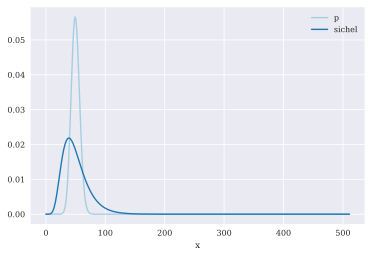

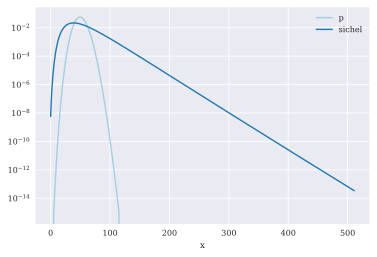

In [431]:
em, df = sichel(*params, 9)
display(df.head())
em

# Combine Sichel in with mixing function

In [485]:
def mixing(n, ν, f, κ, γ_mult, log2, xmax=500, **kwds):
    """
    n = E(N) = expected claim count
    ν = CV(mixing) = asymptotic CV of any compound aggregate whose severity has a second moment
    f = proportion of certain claims, 0 <= f < 1, higher f corresponds to greater skewnesss
    κ = claims per occurrence 
    γ_mult = adjust skewness of Sichel above/below standard PIG
    """
    
    def defuzz(x):
        x[np.abs(x) < 5e-16] = 0
        return x
    
    ma = lambda x : list(MomentAggregator._moments_to_mcvsk(*x))
    
    def row(ps):
        moms = [(x**k * ps).sum() for k in (1,2,3)] 
        stats = ma(moms)
        return moms + stats + [np.nan]

    def Nmoms(n, c, g):
        """ 
        c=Var(G), g=E(G^3) return EN, EN2, EN3 
        """
        return [n, n * (1 + (1 + c) * n), n * (1 + n * (3*(1+c) + n * g))]
    
    def asy_skew(g, c):
        """
        asymptotic skewnewss 
        """
        return [(g - 3 * c - 1) / c**1.5]
    
    ans = pd.DataFrame(columns=['X', 'type', 'EX', 'EX2', 'EX3', 'mean', 'CV', 'Skew',  'Asym Skew'])
    ans = ans.set_index(['X', 'type'])

    N = 1 << log2
    x = np.arange(N, dtype=float)
    z = np.zeros(N)
    z[1] = 1
    fz = ft(z)
        
    # build poisson for comparison
    dist = 'poisson'
    kernel = n * (fz - 1)
    p = np.real(ift(np.exp(kernel)))
    p = defuzz(p)

    # for poisson c=0 and g=1 (the "mixing" distribution is G identically equal to 1)
    ans.loc[(dist, 'empirical'), :] = row(p)
    temp = Nmoms(n, 0, 1)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + [np.inf]
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    # negative binomial
    # Var(G) = c, E(G)=1 so Var(G) = ν^2 = c
    # wikipedia / scipy stats use a and θ for shape and scale
    dist = 'neg bin'
    c = ν * ν   # contagion
    a = 1 / c
    θ = c
    # E(G^3): skew(G) = skew(G') = γ, so E(G-EG)^3 = γν^3, so EG^3 = γν^3 + 3(1+c) - 2 = γν^3 + 3c + 1
    # for Gamma skew = 2 / sqrt(a) = 2ν
    g = 1 + 3*c + 2*c*c
    nb = np.real(ift( (1 - θ * kernel) ** -a))
    nb = defuzz(nb)
    
    ans.loc[(dist, 'empirical'), :] = row(nb)
    # this row is generic: it applies to all distributions 
    temp = Nmoms(n, c, g)   # [n, n * (1 + (1 + c) * n), n*(1 + n * (3*(1+c) + n * g))] # n**3*g + 3*n**2*(1+c)+n]
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
        
    # delaporte G = f + G'
    dist = 'delaporte'
    c = ν * ν   # contagion
    a = ((1 - f) / ν)**2
    θ = (1 - f) / a
    g = 2 * ν**4 / (1-f) + 3 * c + 1
    delaporte = np.real(ift( np.exp(f * kernel) *  (1 - θ * kernel) ** -a))
    delaporte = defuzz(delaporte)
    
    ans.loc[(dist, 'empirical'), :] = row(delaporte)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # pig
    dist = 'pig'
    c = ν * ν   # contagion
    μ = c
    λ = 1 / μ
    # our param (λ, μ) --> (λ, λμ) in Mathematica and hence skew = γ = 3 * sqrt(μ) in scip py parameterization 
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    pig = np.real(ift( np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)) )))
    pig = defuzz(pig)
#     print(f'PIG parameters μ={μ} and λ={λ}, g={g}, γ={γ}')
    ans.loc[(dist, 'empirical'), :] = row(pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # shifted pig
    dist = 'shifted pig'
    c = ν * ν   # contagion
    μ = c / (1 - f)**2 
    λ = (1 - f) / μ
    γ = 3 * np.sqrt(μ) 
    g = γ * ν**3 + 3 * c + 1
    shifted_pig = np.real(ift(  np.exp(f * kernel) * np.exp( 1/μ * (1 - np.sqrt(1 - 2 * μ**2 * λ * kernel)))))
    shifted_pig = defuzz(shifted_pig)
    
    ans.loc[(dist, 'empirical'), :] = row(shifted_pig)
    temp = Nmoms(n, c, g)
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    #  poisson pascal 
    # parameters 
    dist = 'poisson pascal'
    # solve for local c to hit overall c=ν^2 value input
    c = (n * ν**2 - 1 - κ) / κ
    a = 1 / c
    θ = κ * c
    λ = n / κ   # poisson parameter for number of claims
    pois_pascal = np.real(ift( np.exp(λ * ((1 - θ * (fz - 1))**-a - 1))))
    pois_pascal = defuzz(pois_pascal)
    
    ans.loc[(dist, 'empirical'), :] = row(pois_pascal)
    # moments for the PP are different can't use Nmoms
    g = κ*λ*(2*c**2*κ**2 + 3*c*κ**2*λ + 3*c*κ**2 + 3*c*κ + κ**2*λ**2 + 3*κ**2*λ + κ**2 + 3*κ*λ + 3*κ + 1)
    g2 = n*(2*c**2*κ**2 + 3*c*n*κ + 3*c*κ**2 + 3*c*κ + n**2 + 3*n*κ + 3*n + κ**2 + 3*κ + 1)
    assert np.allclose(g, g2)
    temp = [λ * κ, n * (κ * (1 + c + λ) + 1), g]
    ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + [np.nan]  # note: hard to interpret this, but for FIXED cv of NB it tends to zero
    ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1
    
    # sichel: find sichel to increase mixing skewness indicated amount from IG skewness
    dist = 'sichel'
    # starting parameters = IG estimates in Panjer Willmot p.282 (8.3.12) and (8.3.13) format 
def sichel_solver2(n, ν, γ_mult):
    """
    find method of moments parameters for Sichel mixed with GIG whose skewness = γ_mult x IG(n, ν) 
    """
    # starting parameters = IG estimates in Panjer Willmot p.282 (8.3.12) and (8.3.13) format 
    c = ν ** 2
    λ = -0.5
    μ = n
    β = ν**2 * n
    ig_param = (μ, β, λ)
    # EG^3
    ig_fact = tuple((μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1, 2,3)))
    mw = MomentWrangler()
    mw.factorial = ig_fact
    γ_base = mw.stats['skew']
    sd_base = mw.stats['sd']
    eg, eg2, eg3 = mw.noncentral 
    print(eg, eg2, eg3)
    γ = γ_base * γ_mult
    # adjust the third moment (mean and std dev unchanged)
    eg3_target = γ * sd_base**3 + 3 * eg2 * eg - 2 * eg**3
    mw.noncentral = (eg, eg2, eg3_target)
    target = np.array(mw.factorial)
    print(target)

    def f(arrIn):
        μ, β, λ = arrIn
        # mu and beta are positive... 
        μ = np.exp(μ)
        β = np.exp(β)
        return np.array([μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]) - target

    try:
        ans = broyden2(f, (np.log(μ), np.log(β), λ), verbose=False, iter=10000, f_rtol=1e-11) # , f_rtol=1e-9)  , line_search='wolfe'
    except NoConvergence as e:
        print('ERROR: broyden did not converge')
        print(e)
        raise e
    μ, β, λ = ans
    ans = (np.exp(μ), np.exp(β), λ)
    print('ig', ig_param, 'gig', ans)
    return ans

    # if parameters found... 
    if add_sichel:
        print('starting params:', μ, β, λ)
        print('\nfit params:    ', *params)
        μ, β, λ = params 
        kernel = (fz - 1)  # not n*(fz-1)
        # theoretic factorial moments of the **mixing** distribution 
        mw.factorial = [μ**r * kv(λ + r, μ / β) / kv(λ, μ / β) for r in (1,2,3)]
        print('Actual vs. target: ', mw.factorial, target)
        print('stats\n', mw.stats)
        # compute density 
        inner = np.sqrt(1 - 2 * β * kernel)
        sichel = np.real(ift( inner**(-λ) * kv(λ, μ * inner / β) /  kv(λ, μ / β) ))
        sichel = defuzz(sichel)
    
        ans.loc[(dist, 'empirical'), :] = row(sichel)
        g = mw.noncentral[2] / n**3  # non central from factorial 
        temp = Nmoms(n, c, g)
        ans.loc[(dist, 'theoretical'), :] = temp + ma(temp) + asy_skew(g, c)  
        ans.loc[(dist, 'diff'), :] = ans.loc[(dist, 'empirical'), :] / ans.loc[(dist, 'theoretical'), :] - 1

    # ---------------------------------------------------------------------
    # sum of all errors is small 
    print( ans.loc[(slice(None), 'diff'), :].abs().sum().sum() )
    # assert ans.loc[(slice(None), 'diff'), :].abs().sum().sum() < 1e-6
    
    # graphics
    df = pd.DataFrame(dict(x=x, poisson=p, pois_pascal=pois_pascal, negbin=nb,delaporte=delaporte,  pig=pig,  
                           shifted_pig=shifted_pig, sichel=sichel))
    df = df.query(f' x < {xmax} ')
    df = df.set_index('x')
    axiter = agg.axiter_factory(None, 12, aspect=1.414, nr=6)
    all = ['poisson', 'negbin', 'delaporte', 'pig', 'shifted_pig', 'pois_pascal', 'sichel']
    for vars in [all,
                 ['poisson', 'negbin', 'pig', ],
                 ['poisson', 'negbin', 'delaporte', ],
                 ['poisson', 'pig', 'shifted_pig',  'sichel'],
                 ['poisson', 'negbin', 'pois_pascal'],
                 ['poisson', 'delaporte', 'shifted_pig', 'sichel'],
                ]:
        # keep the same colors 
        pal = [sns.color_palette("Paired", 7)[i] for i in [all.index(j) for j in vars]]
        df[vars].plot(kind='line', ax=next(axiter), color=pal )
        axiter.ax.set_xlim(0, 4*n)
        df[vars].plot(kind='line', logy=True, ax=next(axiter), legend=None, color=pal )    
    axiter.tidy()
    display(ans.unstack())
    return df, ans

starting params: 100 20.25 -0.5

fit params:     100.300742093 21.8457473324 -0.547552369405
Actual vs. target:  [99.360585322225745, 12024.410166506066, 1762655.576483469] [  1.00000000e+02   1.20250000e+04   1.76281719e+06]
stats
 ex        99.360585
var     2251.244836
sd        47.447285
cv         0.477526
skew       1.374644
dtype: float64
0.386707268469


EX                                EX2              \
type           empirical theoretical         diff empirical theoretical   
X                                                                         
poisson              100         100 -2.53131e-14     10100       10100   
neg bin              100         100  -2.4547e-13     12125       12125   
delaporte            100         100 -4.77396e-13     12125       12125   
pig                  100         100 -4.43423e-13     12125       12125   
shifted pig          100         100 -1.17995e-12     12125       12125   
poisson pascal       100         100 -2.21934e-13     12025       12025   
sichel           99.3606         100  -0.00639415   12123.8       12125   

                                     EX3                                mean  \
type                   diff    empirical  theoretical         diff empirical   
X                                                                              
poisson        -4.82947e-14   1.0301e+06      1030100 -7.88258e-14       100   
neg bin        -1.38201e-12  1.72569e+06  1.72569e+06  -7.6894e-12       100   
delaporte      -4.42502e-12   1.8077e+06   1.8077e+06  -3.8297e-11       100   
pig            -3.82205e-12  1.76669e+06  1.76669e+06 -3.14663e-11       100   
shifted pig    -1.90861e-11  1.88971e+06  1.88971e+06 -2.62924e-10       100   
poisson pascal -1.17428e-12  1.68508e+06  1.68508e+06 -6.19738e-12       100   
sichel         -0.000101381  1.79883e+06    1.835e+06   -0.0197139   99.3606   

                                               CV                           \
type           theoretical         diff empirical theoretical         diff   
X                                                                            
poisson                100 -2.53131e-14       0.1         0.1  1.16129e-13   
neg bin                100  -2.4547e-13  0.460977    0.460977 -2.54252e-12   
delaporte              100 -4.77396e-13  0.460977    0.460977 -9.90064e-12   
pig                    100 -4.43423e-13  0.460977    0.460977 -8.37419e-12   
shifted pig            100 -1.17995e-12  0.460977    0.460977 -4.77191e-11   
poisson pascal         100 -2.21934e-13      0.45        0.45 -2.16827e-12   
sichel                 100  -0.00639415  0.477526    0.460977    0.0358998   

                    Skew                          Asym Skew                   
type           empirical theoretical         diff empirical theoretical diff  
X                                                                             
poisson              0.1         0.1 -9.80618e-11       NaN         inf  NaN  
neg bin         0.900261    0.900261 -9.16779e-11       NaN         0.9  NaN  
delaporte        1.73749     1.73749 -2.87677e-10       NaN         1.8  NaN  
pig              1.31887     1.31887  -3.0434e-10       NaN        1.35  NaN  
shifted pig      2.57471     2.57471 -1.55906e-09       NaN         2.7  NaN  
poisson pascal  0.851372    0.851372 -7.96727e-11       NaN         NaN  NaN  
sichel           1.37464     2.01621    -0.318204       NaN     2.09962  NaN

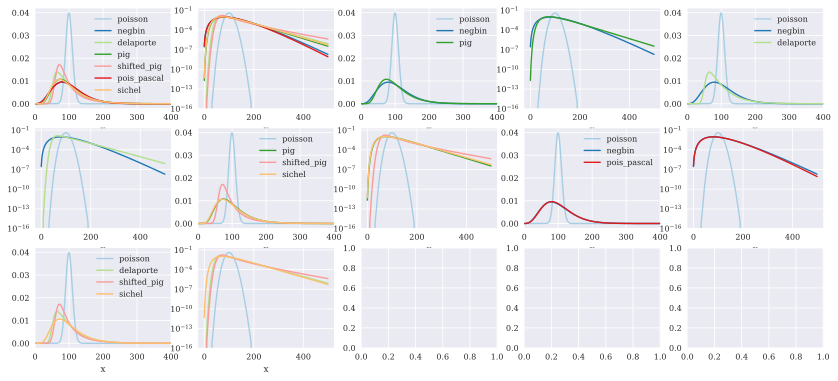

In [489]:
df, ans = mixing(n=100, ν=0.45, f=0.5, κ=1.25, γ_mult=1.25, log2=16, xmax=500) 

## Poisson Pascal Calculations with MGF for Moments

In [588]:
import sympy as sym
sym.init_printing(use_unicode=True)
sym.init_printing(use_latex=True)

In [552]:
x = sym.Symbol('x', real=True)
λ = sym.Symbol('λ', real=True)
κ = sym.Symbol('κ', real=True)
c = sym.Symbol('c', real=True)
n = sym.Symbol('n', real=True)

In [553]:
sym.simplify(sym.diff(sym.exp((n/κ)*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 1).subs(x, 0))

In [554]:
sym.simplify(sym.diff(sym.exp((n/κ)*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 2).subs(x, 0))

In [555]:
sym.simplify(sym.diff(sym.exp(λ*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 3).subs(x, 0))

In [469]:
print(sym.simplify(sym.diff(sym.exp(λ*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 3).subs(x, 0)))

κ*λ*(2*c**2*κ**2 + 3*c*κ**2*λ + 3*c*κ**2 + 3*c*κ + κ**2*λ**2 + 3*κ**2*λ + κ**2 + 3*κ*λ + 3*κ + 1)


In [519]:
sym.latex(sym.simplify(sym.diff(sym.exp(λ*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 3).subs(x, 0)))

'κ λ \\left(2 c^{2} κ^{2} + 3 c κ^{2} λ + 3 c κ^{2} + 3 c κ + κ^{2} λ^{2} + 3 κ^{2} λ + κ^{2} + 3 κ λ + 3 κ + 1\\right)'

In [556]:
en3 = sym.simplify(sym.diff(sym.exp((n/κ)*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 3).subs(x, 0))
en2 = sym.simplify(sym.diff(sym.exp((n/κ)*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 2).subs(x, 0))
en1 = sym.simplify(sym.diff(sym.exp((n/κ)*((1 - κ * c *(sym.exp(x) - 1))**(-1/c) - 1)), x, 1).subs(x, 0))

In [557]:
en1, en2, en3

In [558]:
cent = sym.simplify(en3 - 3 * en2 * en1 + 2 * en1**3)
cent

In [560]:
sym.limit(cent / (en2 - en1*en1)**(3/2), n, sym.oo)

In [559]:
sym.simplify(en2 - en1*en1)

In [561]:
print(en3)

n*(2*c**2*κ**2 + 3*c*n*κ + 3*c*κ**2 + 3*c*κ + n**2 + 3*n*κ + 3*n + κ**2 + 3*κ + 1)


In [577]:
f = sym.Function('f')
t = sym.Symbol('t')

In [590]:
display(sym.diff(f(sym.exp(t)), t, 2))

⎛     2                             ⎞   
⎜ t  d  ⎛ ⎛ t⎞⎞   ⎛ d        ⎞│     ⎟  t
⎜ℯ ⋅────⎝f⎝ℯ ⎠⎠ + ⎜───(f(ξ₁))⎟│    t⎟⋅ℯ 
⎜      2          ⎝dξ₁       ⎠│ξ₁=ℯ ⎟   
⎜     t                             ⎟   
⎝   dℯ                              ⎠   

In [580]:
sym.diff(sym.exp(t), t)

# Moment Wrangler

In [304]:
class MomentWrangler(object):
    
       
    def __init__(self):
        self._central = None
        self._noncentral = None
        self._factorial = None

    @property
    def central(self):
        return self._central
    
    @central.setter
    def central(self, value):
        self._central = value
        ex1, ex2, ex3 = value
        # p 43, 1.241 
        self._noncentral = (ex1, ex2 + ex1**2, ex3 + 3 * ex2 * ex1 + ex1**3)
        self._make_factorial()
        
    @property 
    def noncentral(self):
        return self._noncentral
    
    @noncentral.setter
    def noncentral(self, value):
        self._noncentral = value
        self._make_factorial() 
        self._make_central()

    @property 
    def factorial(self):
        return self._factorial
    
    @factorial.setter
    def factorial(self, value):
        self._factorial = value
        ex1, ex2, ex3 = value
        # p 44, 1.248
        self._noncentral = (ex1, ex2 + ex1, ex3 + 3 * ex2 + ex1)
        self._make_central()
        
    @property
    def stats(self):
        m, v, c3 = self._central
        sd = np.sqrt(v)
        if m == 0:
            cv = np.nan
        else:
            cv = sd / m
        if sd == 0:
            skew = np.nan
        else:
            skew = c3 / sd**3
#         return pd.Series((m, v, sd, cv, skew), index=('EX', 'Var(X)', 'SD(X)', 'CV(X)', 'Skew(X)'))
        # shorter names are better
        return pd.Series((m, v, sd, cv, skew), index=('ex', 'var', 'sd', 'cv', 'skew'))

    
    def _make_central(self):
        ex1, ex2, ex3 = self._noncentral
        # p 42, 1.240
        self._central = (ex1, ex2 - ex1**2, ex3 - 3 * ex2 * ex1 + 2* ex1**3)

    def _make_factorial(self):
        """ add factorial from central """
        ex1, ex2, ex3 = self._noncentral
        # p. 43, 1.245 (below)
        self._factorial = (ex1, ex2 - ex1, ex3 - 3 * ex2 + 2 * ex1)
        
        

In [305]:
mw = MomentWrangler()

In [306]:
mw.central = (1, 10, 100) 

In [307]:
mw.noncentral

(1, 11, 131)

In [308]:
mw.factorial

(1, 10, 100)

In [309]:
mw.central

(1, 10, 100)

In [310]:
mw.stats['cv']

3.1622776601683795

In [311]:
mw.stats = 12

AttributeError: can't set attribute